In [1]:
##DESCRIPTION
# This notebook calculates the so called "Polygons" to describe how a system under test reacts to a set of performance tests.


In [86]:
#install.packages("RColorBrewer", repos='http://cran.us.r-project.org')
#install.packages("gridExtra")
#install.packages("getPass")
#install.packages("RPostgreSQL")

library("RColorBrewer")
library(ggplot2)
library(gridExtra)
library(getPass)
library(RPostgreSQL)
library(dplyr)
library(stringr)

In [87]:
db_connection <- DBI::dbConnect(dbDriver(drvName = "PostgreSQL"), dbname = Sys.getenv("DB_NAME"), host=Sys.getenv("HOST_NAME"), port="5432", user=Sys.getenv("POSTGRES_USERNAME"), password=Sys.getenv("POSTGRES_PASSWORD"))
dbGetQuery(db_connection, "SELECT id::text, name FROM projects") 

,id,name
,<chr>,<chr>
1,9eed4fb9-ccd3-4b27-8a9a-7cb357e3fea2,todolist


In [88]:
# Define the name of the project to analyze
project_name <- "todolist"

project_id = dbGetQuery(db_connection, str_glue("SELECT id::text FROM projects WHERE name='{project}'", project = project_name))$id

In [89]:
sql_operational_profile = "
    SELECT users, frequency FROM operational_profile_observations 
        WHERE operational_profile = (SELECT id FROM operational_profiles WHERE project = ?project)"
operational_profile <- dbGetQuery(db_connection, sqlInterpolate(db_connection, sql_operational_profile, project = project_id))

In [90]:
sql_all_data = "
    SELECT tests.id::text AS test_id, test_sets.id::text AS test_set_id, test_properties.value::numeric AS users, metrics.abbreviation AS metric, items.name AS item_name, results.value AS item_value
        FROM results 
        INNER JOIN tests ON results.test = tests.id
        INNER JOIN items ON results.item = items.id
        INNER JOIN test_properties ON (test_properties.test = tests.id AND test_properties.name = 'load')
        INNER JOIN metrics ON results.metric = metrics.id 
        INNER JOIN test_set_tests ON (test_set_tests.test = tests.id)
        INNER JOIN test_sets ON (test_sets.id = test_set_tests.test_set AND test_sets.project = tests.project)
        WHERE tests.project = ?project AND metrics.abbreviation IN ('art', 'sdrt', 'mix')"
all_data = dbGetQuery(db_connection, sqlInterpolate(db_connection, sql_all_data, project = project_id))

list_of_microservices = as.data.frame(unique(all_data[,5]))
no_of_microservices = nrow(list_of_microservices)

test_users_metric<-unique(all_data[,c(1:4)])

In [91]:
test_users_metric[list_of_microservices[,1]]<-NA

In [92]:
#If the tests occur too fast, it might be that some services have no data. This case is not handled, yet.

for (i in 1:nrow(test_users_metric)) {
    search_test_id <- test_users_metric[i,1]
    search_metric <- test_users_metric[i,4]
    
    for (j in 1:no_of_microservices) {
        search_microservice <- list_of_microservices[j,]
        
        row <- filter(all_data, test_id == search_test_id & metric == search_metric & item_name == search_microservice)
        
        if (dim(row)[1] > 0) {
            found_value = row$item_value
            
            if (length(found_value) == 1) {
                test_users_metric[i,j+4] <- found_value
            }
        }
    }
}
raw_data <- test_users_metric
raw_data


,test_id,test_set_id,users,metric,ToDo-Create,ToDo-Delete,ToDo-Get-All,ToDo-Get-Single,ToDo-Update
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,aa54e9ad-41fb-4acc-8352-dba246e8fef2,6fbb41ba-f520-4444-9098-0a26fd20cc34,1,art,227.7500000,3.140000e+02,222.5000000,212.6250000,206.6000000
2,aa54e9ad-41fb-4acc-8352-dba246e8fef2,6fbb41ba-f520-4444-9098-0a26fd20cc34,1,sdrt,28.8888889,8.185185e+01,51.1111111,24.4444444,16.2962963
3,aa54e9ad-41fb-4acc-8352-dba246e8fef2,6fbb41ba-f520-4444-9098-0a26fd20cc34,1,mix,0.1666667,5.555556e-02,0.1666667,0.3333333,0.2777778
16,47dbdcf8-106c-4fae-b5e1-0c5847634d12,6fbb41ba-f520-4444-9098-0a26fd20cc34,10,art,350.9913793,2.746615e+02,243.1578947,216.9484979,240.2487047
17,47dbdcf8-106c-4fae-b5e1-0c5847634d12,6fbb41ba-f520-4444-9098-0a26fd20cc34,10,sdrt,44.4444444,3.925926e+01,29.4444444,40.0000000,41.4814815
18,47dbdcf8-106c-4fae-b5e1-0c5847634d12,6fbb41ba-f520-4444-9098-0a26fd20cc34,10,mix,0.1608877,9.015257e-02,0.1581137,0.3231623,0.2676838
31,0f175210-96e4-4881-97dc-a408bffd55be,6fbb41ba-f520-4444-9098-0a26fd20cc34,20,art,150.3750000,1.832114e+02,182.7805907,150.8372093,152.1580311
32,0f175210-96e4-4881-97dc-a408bffd55be,6fbb41ba-f520-4444-9098-0a26fd20cc34,20,sdrt,26.6666667,3.666667e+01,38.5185185,25.9259259,26.6666667
33,0f175210-96e4-4881-97dc-a408bffd55be,6fbb41ba-f520-4444-9098-0a26fd20cc34,20,mix,0.1644962,8.430432e-02,0.1624400,0.3241947,0.2645648


In [93]:
tests <- unique(raw_data[,1:3])

max_no_of_users <- max(raw_data[,3])
min_no_of_users <- min(raw_data[,3])

user_load <- operational_profile[,1]
access_count <- operational_profile[,2]
max_no_of_requests <- max(user_load)
scale_factor <- max_no_of_users/max_no_of_requests
scaled_user_load <- floor(scale_factor * user_load)

In [94]:
##Create aggregate values (by fifty) of the user frequency from "operational_profile" 
steps <- 10

calculate_aggregated_values <- function() {    
    access_frequency <- access_count/sum(access_count)
    by_fifty <- which(scaled_user_load %% steps == 0)
    no_of_aggregated_rows = length(by_fifty)

    binProb <- c()
    for (i in 1:no_of_aggregated_rows) {
        if (i==1) {
            binProb[i] <- sum(access_frequency[1:by_fifty[i]])
        } else {
            binProb[i] <- sum(access_frequency[(by_fifty[i-1]+1):by_fifty[i]])
        }
    }

    matrix(c(scaled_user_load[by_fifty], binProb), ncol=2, nrow=no_of_aggregated_rows, dimnames=list(c(1:no_of_aggregated_rows), c("Workload (number of users)", "Domain metric per workload")))
}

aggregated_values_from_operational_profile <- calculate_aggregated_values()
aggregated_values_from_operational_profile

,Workload (number of users),Domain metric per workload
1,10,0.00000000
2,20,0.11267606
3,30,0.03943662
4,40,0.15774648
5,50,0.09295775
6,60,0.14366197
7,70,0.08732394
8,80,0.14929577
9,90,0.12394366
10,100,0.09295775


In [95]:
#Define the threshold for each service. The threshold is a vector computed as avg+3*SD for the configuration with 
#Users=2, Memory=4, CPU=1, CartReplica=1   

data_of_min_user<-raw_data[raw_data$users==min_no_of_users,]
test_of_min_user<-tests[tests$users==min_no_of_users,]

avg <-data_of_min_user[data_of_min_user$metric=="art",][,-c(1:4)]
sd <- data_of_min_user[data_of_min_user$metric=="sdrt",][,-c(1:4)]
threshold<-data.frame(test_of_min_user,avg+3*sd)

#Check the first line of the dataframe thereshold: it must be one line
head(threshold)
data_of_min_user

,test_id,test_set_id,users,ToDo.Create,ToDo.Delete,ToDo.Get.All,ToDo.Get.Single,ToDo.Update
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,aa54e9ad-41fb-4acc-8352-dba246e8fef2,6fbb41ba-f520-4444-9098-0a26fd20cc34,1,314.4167,559.5556,375.8333,285.9583,255.4889


,test_id,test_set_id,users,metric,ToDo-Create,ToDo-Delete,ToDo-Get-All,ToDo-Get-Single,ToDo-Update
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,aa54e9ad-41fb-4acc-8352-dba246e8fef2,6fbb41ba-f520-4444-9098-0a26fd20cc34,1,art,227.7500000,314.00000000,222.5000000,212.6250000,206.6000000
2,aa54e9ad-41fb-4acc-8352-dba246e8fef2,6fbb41ba-f520-4444-9098-0a26fd20cc34,1,sdrt,28.8888889,81.85185185,51.1111111,24.4444444,16.2962963
3,aa54e9ad-41fb-4acc-8352-dba246e8fef2,6fbb41ba-f520-4444-9098-0a26fd20cc34,1,mix,0.1666667,0.05555556,0.1666667,0.3333333,0.2777778


In [96]:
#Exclude case with user = 2 from dataFile and check whether each service passes or fail: avg<threshol (Pass). 
#Compute the relative mass for each configuration

tests_without_benchmark<-tests[!tests$users==min_no_of_users,]
raw_data_without_benchmark<-raw_data[!raw_data$users==min_no_of_users,]

avg<-raw_data_without_benchmark[raw_data_without_benchmark$metric=="art",-4]
sd<-raw_data_without_benchmark[raw_data_without_benchmark$metric=="sdrt",-4]
mix<-raw_data_without_benchmark[raw_data_without_benchmark$metric=="mix",-4]

#Check pass/fail for each service. the "mix" value is 0 if fail and mixTemp if pass. Compute the relative mass for each configuration
pass_criteria<-avg

calculate_relative_mass <- function() {    
    relative_mass<-c()

    mix_of_passing_tests<-as.data.frame(matrix(nrow=nrow(tests_without_benchmark), ncol=ncol(raw_data_without_benchmark)-1))

    for(j in 1:nrow(pass_criteria)){
        mix_of_passing_tests[j,]<-mix[j,]
        for(i in 3:(2+no_of_microservices)){
            if(pass_criteria[j,i]>threshold[i]){
                mix_of_passing_tests[j,i]<-0
            }
        }
        relative_mass[j]<-sum(mix_of_passing_tests[j,3:(2+no_of_microservices)])
    }
   
    relative_mass
}

relative_mass <- calculate_relative_mass()

#Show first lines of passCriteria
head(pass_criteria)

,test_id,test_set_id,users,ToDo-Create,ToDo-Delete,ToDo-Get-All,ToDo-Get-Single,ToDo-Update
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16,47dbdcf8-106c-4fae-b5e1-0c5847634d12,6fbb41ba-f520-4444-9098-0a26fd20cc34,10,350.9914,274.6615,243.1579,216.9485,240.2487
31,0f175210-96e4-4881-97dc-a408bffd55be,6fbb41ba-f520-4444-9098-0a26fd20cc34,20,150.3750,183.2114,182.7806,150.8372,152.1580
46,d4ea622a-9b64-4786-8d37-637926c1b872,6fbb41ba-f520-4444-9098-0a26fd20cc34,30,143.2028,151.0652,164.5141,128.4278,139.3990
61,e245402e-6c67-4320-a94b-fd2e603cae07,6fbb41ba-f520-4444-9098-0a26fd20cc34,40,246.0343,268.5587,265.1727,236.3056,262.9556
76,efa1395c-886c-43e6-9716-9c7c18bfaa87,6fbb41ba-f520-4444-9098-0a26fd20cc34,50,295.2517,297.1827,212.7242,144.9492,274.9593
91,5996902f-b33d-4afb-9f0d-d0bc49004fbb,6fbb41ba-f520-4444-9098-0a26fd20cc34,60,530.5685,485.1390,346.1750,235.2125,453.9842


In [97]:
#Compute the domain metric for each configuration
tests_without_benchmark$relative_mass<-relative_mass

absolute_mass<-c()
for(j in 1:nrow(tests_without_benchmark)) {
    absolute_mass[j]<-tests_without_benchmark[j,"relative_mass"]*aggregated_values_from_operational_profile[match(tests_without_benchmark[j,"users"], aggregated_values_from_operational_profile[,1]),2]
}
tests_without_benchmark$absolute_mass<-absolute_mass

test_sets<-as.data.frame(unique(all_data[,2]))
colnames(test_sets)[1] <- "test_set_id"

set<-list()
domain_metric_list<-list()
for(i in 1:nrow(test_sets)){
    set[[i]]<-tests_without_benchmark[which(tests_without_benchmark[,2] == test_sets[i,1]),]
    domain_metric_list[[i]]<-set[[i]][,c(3,5)][order(set[[i]][,c(3,5)][,1]),]
}

#Uncomment this to show first lines of domain_metric_list
#head(domain_metric_list)
domain_metric_list

,users,absolute_mass
,<dbl>,<dbl>
16,10,0.00000000
31,20,0.08286594
46,30,0.02872345
61,40,0.11590319
76,50,0.06795707
91,60,0.08224589
106,70,0.00000000
121,80,0.00000000
136,90,0.00000000


In [98]:
#Compute Cumulative Domain metric: summing up absoluteMass over users for each configuration
test_sets$domain_metric<-0
for(i in 1:nrow(test_sets)){
    test_sets[i,2]<-round(sum(tests_without_benchmark[which(tests_without_benchmark[,2] == test_sets[i,1]),"absolute_mass"]),4)
}
domain_metric<-test_sets

domain_metric

test_set_id,domain_metric
<chr>,<dbl>
6fbb41ba-f520-4444-9098-0a26fd20cc34,0.3777
71dcb1e7-70e8-4aed-ad5a-56f91253ec36,0.6458


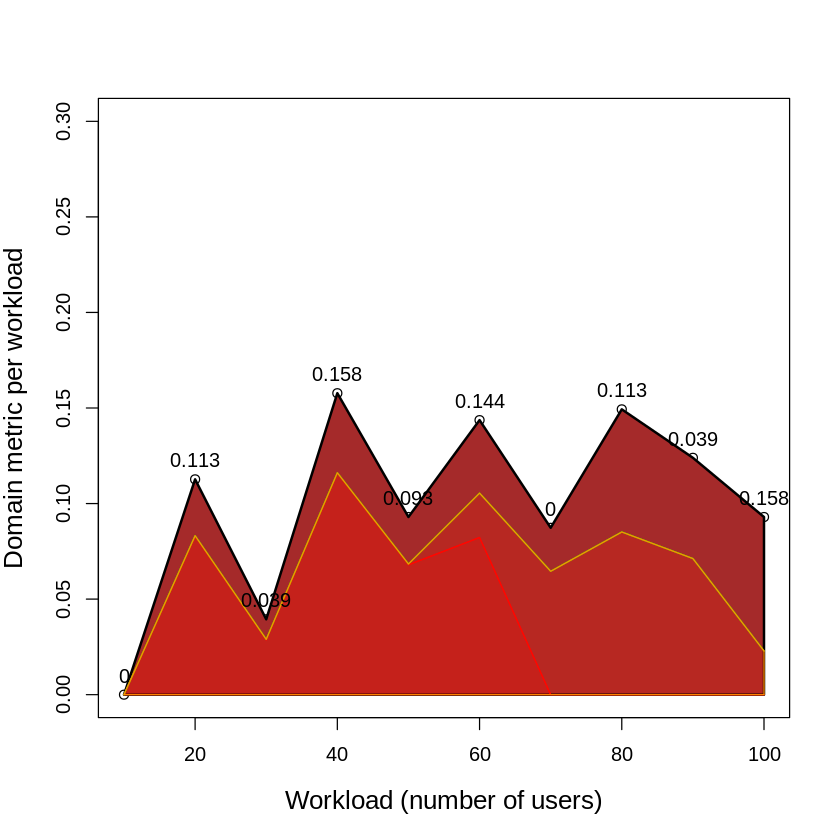

In [102]:
#Plot operational_profile against domain metric for each configuration

plot(aggregated_values_from_operational_profile, xlim=c(steps, max_no_of_users), ylim=c(0, 0.3),cex.lab=1.3)
polygon(c(steps,aggregated_values_from_operational_profile[,1],max_no_of_users),c(0,aggregated_values_from_operational_profile[,2],0), col="brown", lty = 1, lwd = 2, border = "black")
color=heat.colors(11)
color_transparent <- adjustcolor(color, alpha.f = 0.2) 

sorted_domain_metric<-domain_metric
k<-which(sorted_domain_metric[,2]==max(sorted_domain_metric[,2]))
#Green line whithin the polygon is the best domain matric line. 
#It corresponds to the second line in the final table below

for(i in 1:nrow(test_sets)) {
    lines(domain_metric_list[[i]], type="l", col=heat.colors(11)[i])    
    lines(domain_metric_list[[k]], type="l", col="green")
    polygon(c(steps,t(domain_metric_list[[i]][1]),max_no_of_users),c(0,t(domain_metric_list[[i]][2]),0), col=color_transparent[i], lty = 1, lwd = 1 , border = rainbow(11)[i])
}

text(aggregated_values_from_operational_profile,labels = round(aggregated_values_from_operational_profile[,2],3), pos=3, col="black")

graphics.off()

In [11]:
DBI::dbDisconnect(db_connection)

[1] TRUE